<a href="https://colab.research.google.com/github/Garima27dec/Emotion-Detection-with-Multiple-Data-Streams/blob/main/BERT_Text_Sentiment_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_hub as hub

In [ ]:
!pip install -U tensorflow-text==2.12.0
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Emotion_Recognition/Text_ER/tweet_emotions.csv')

In [4]:
dataset.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
dataset = dataset.drop(['tweet_id'],axis=1)
dataset.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
print(dataset['sentiment'].unique())

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [ ]:
dataset['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [5]:
dataset['sentiment'] = dataset['sentiment'].replace(["worry","happiness","sadness","love","surprise","fun","relief","hate","empty","enthusiasm", "boredom", "anger","neutral"], ["Fear","Happy","Sad","Happy","Surprise","Happy","Neutral","Disgust","Sad","Happy","Sad","Angry", "Neutral"])

In [6]:
dataset['sentiment'].value_counts()

Happy       11586
Neutral     10164
Fear         8459
Sad          6171
Surprise     2187
Disgust      1323
Angry         110
Name: sentiment, dtype: int64

In [7]:
X= dataset.drop('sentiment',axis=1)
y = dataset['sentiment']

In [8]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.25)

In [9]:
y_train.value_counts()

Happy       8698
Neutral     7646
Fear        6326
Sad         4605
Surprise    1650
Disgust      988
Angry         87
Name: sentiment, dtype: int64

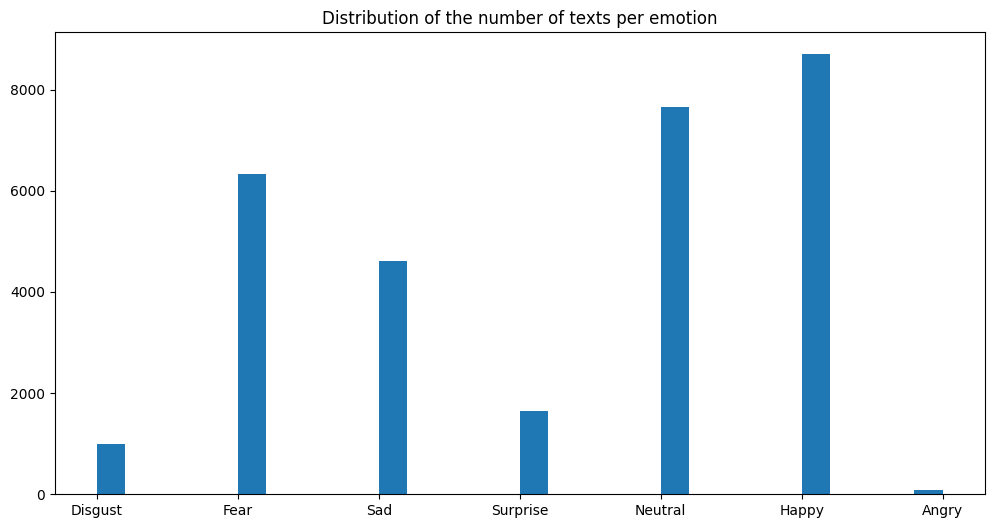

In [10]:
plt.figure(figsize=(12,6))
plt.hist(y_train, bins=30)
plt.title("Distribution of the number of texts per emotion")
plt.show()

In [11]:
from imblearn.over_sampling import RandomOverSampler
import statistics

In [12]:
ros = RandomOverSampler(sampling_strategy= {'Angry': round(statistics.mean(y_train.value_counts())), 'Disgust': round(statistics.mean(y_train.value_counts())), 'Surprise': round(statistics.mean(y_train.value_counts()))})
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [13]:
y_ros.value_counts()

Happy       8698
Neutral     7646
Fear        6326
Sad         4605
Disgust     4286
Surprise    4286
Angry       4286
Name: sentiment, dtype: int64

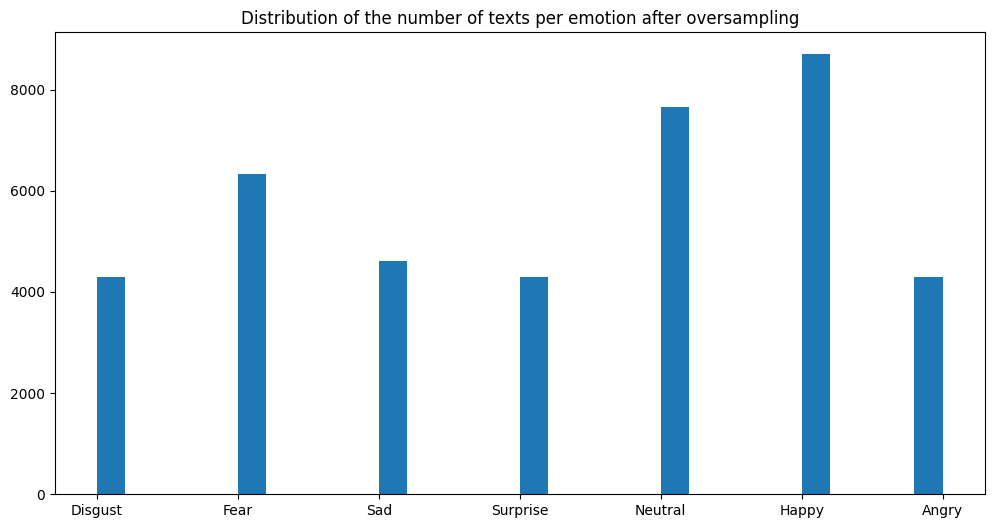

In [14]:
plt.figure(figsize=(12,6))
plt.hist(y_ros, bins=30)
plt.title("Distribution of the number of texts per emotion after oversampling")
plt.show()

In [ ]:
labels_train, features_train = [],[]

labels_train = pd.get_dummies(y_ros).values

dataset_train = X_ros

#converting content column in train and val set to text so as to convert any floating point/int content to str
features_train = dataset_train.content.astype(str).values

In [ ]:
labels_val, features_val = [],[]

labels_val = pd.get_dummies(y_val).values

dataset_val = X_val

#converting content column in train and val set to text so as to convert any floating point/int content to str
features_val = dataset_val.content.astype(str).values

In [ ]:
labels_train

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [ ]:
features_train

array(['my entire body hurts.  shower, hot tea and tv please..',
       '@novemberlight I sometimes fail',
       '@DarryleP LOL! I do splurge on chocolate now and then.  And I plan on splurging a little tomorrow!',
       ...,
       '@bencollieruk No because why would it say &quot;New gift services&quot; on the page.. HA!',
       "Bailey's here.",
       'why is it still raining?!  at least i have cute rainboots'],
      dtype=object)

In [ ]:
X_train = features_train
X_val = features_val
y_train = labels_train
y_val = labels_val

print("Input training features and label shape are {},{}".format(X_train.shape,y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,y_val.shape))

Input training features and label shape are (40131,),(40131, 7)
Input validation features and label shape are (10000,), (10000, 7)


In [ ]:
bert_model_name_encoder = 'bert_en_uncased_L-12_H-768_A-12'
encoder_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model_name_preprocess = 'bert_en_uncased_L-12_H-768_A-12'
preprocess_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
print(f'BERT model selected           : {encoder_download_link}')
print(f'Preprocess model auto-selected: {preprocess_download_link}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocessor = hub.KerasLayer(preprocess_download_link, name='preprocessing')
bert_encoder = hub.KerasLayer(encoder_download_link, name='BERT_encoder')

In [ ]:
def classifier_model():
  text_input = Input(shape =(), dtype= tf.string, name='text')
  #preprocesing layer
  preprocessed_text = bert_preprocessor(text_input)
  #passing through encoder layer
  embeddings = bert_encoder(preprocessed_text)
  #fetching the pooled_output from the dictionary of outputs
  output = embeddings['pooled_output']
  #output = Dropout(0.2)(output)
  #passing through final dense layer
  output = Dense(7, activation='softmax', name='classifier_end')(output)
  return Model(text_input, output)
classifier = classifier_model()

In [ ]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
loss = CategoricalCrossentropy(from_logits=False)
metrics = CategoricalAccuracy()
optimizer = 'adam'

In [ ]:
classifier.compile(optimizer = optimizer, loss=loss, metrics=metrics)

In [ ]:
#fitting the model
history = classifier.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=20)

Epoch 1/20
1255/1255 [==============================] - 548s 426ms/step - loss: 1.8189 - categorical_accuracy: 0.2784 - val_loss: 1.7206 - val_categorical_accuracy: 0.3289
Epoch 2/20
1255/1255 [==============================] - 571s 455ms/step - loss: 1.7389 - categorical_accuracy: 0.3214 - val_loss: 1.6652 - val_categorical_accuracy: 0.3756
Epoch 3/20
1255/1255 [==============================] - 534s 426ms/step - loss: 1.7022 - categorical_accuracy: 0.3410 - val_loss: 1.7519 - val_categorical_accuracy: 0.3180
Epoch 4/20
1255/1255 [==============================] - 534s 425ms/step - loss: 1.6862 - categorical_accuracy: 0.3489 - val_loss: 1.6244 - val_categorical_accuracy: 0.3831
Epoch 5/20
1255/1255 [==============================] - 572s 456ms/step - loss: 1.6687 - categorical_accuracy: 0.3567 - val_loss: 1.5584 - val_categorical_accuracy: 0.4026
Epoch 6/20
1255/1255 [==============================] - 573s 457ms/step - loss: 1.6561 - categorical_accuracy: 0.3617 - val_loss: 1.5573 - v

Text(0.5, 1.0, 'Accuracy Curves')

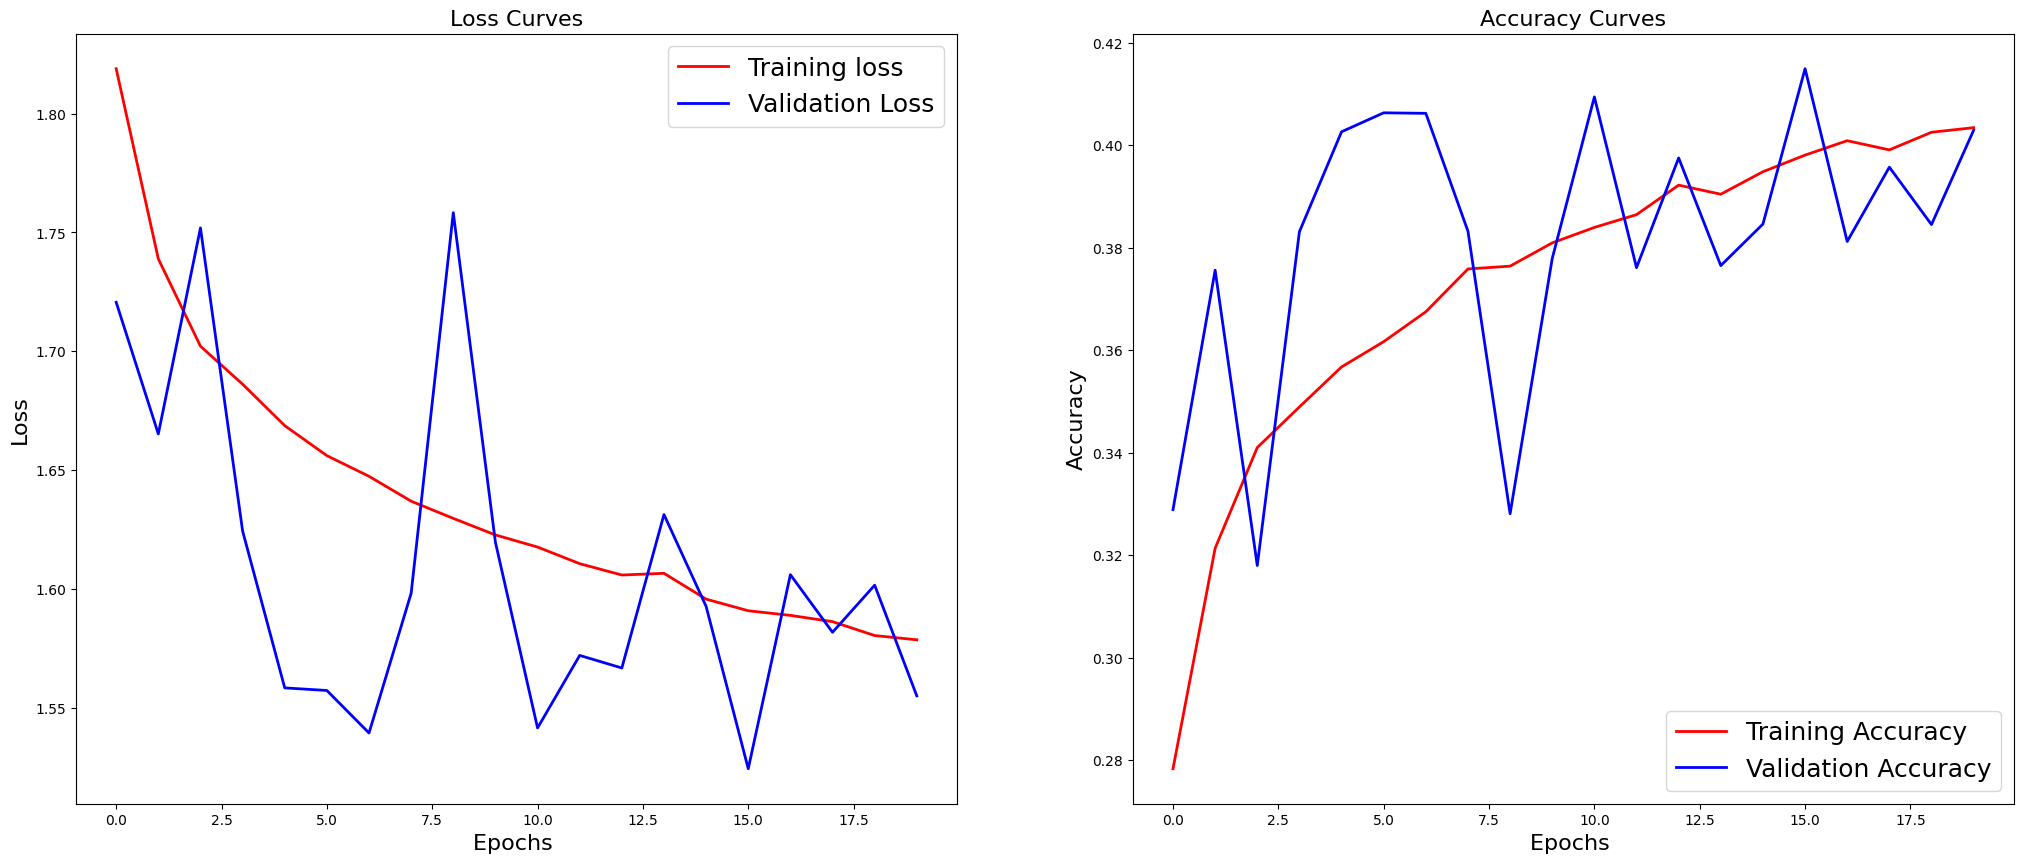

In [ ]:
#Plotting accuracy and loss curves for the model

# Loss Curves
plt.figure(figsize=[25,10])
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#Saving Model

classifier.save('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_M.h5')
classifier.save_weights('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_W.h5')

In [ ]:
#Load model

from keras.models import load_model
model_ter = tf.keras.models.load_model(('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_M.h5'), custom_objects={'KerasLayer':hub.KerasLayer})
model_ter.load_weights('/content/drive/MyDrive/Emotion_Recognition/Text_ER/BERT_W.h5')
print("Loaded model from disk")

Loaded model from disk


In [ ]:
test_string1 = ["Wow! You look beautiful!"]
test_string2 = ["Today is a sunny day."]
test_string3 = ["This is the last day we see each other."]

def predict(test_string):
  class_prob = classifier.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    print("Angry")
  elif np.argmax(class_prob)==1:
    print("Disgust")
  elif np.argmax(class_prob)==2:
    print("Fear")
  elif np.argmax(class_prob)==3:
    print("Happy")
  elif np.argmax(class_prob)==4:
    print("Neutral")
  elif np.argmax(class_prob)==5:
    print("Sad")
  else:
    print("Surprise")

predict(test_string1)
predict(test_string2)
predict(test_string3)

1/1 [==============================] - 0s 62ms/step
Happy
1/1 [==============================] - 0s 65ms/step
Happy
1/1 [==============================] - 0s 40ms/step
Fear
